In [1]:
import numpy as np
import pandas as pd

# 练习4：
# 使用练习1中的数据，将用户数据向量化
# 向量化的结果进行降维可视化（PCA主成分分析）

DATA_FILE = "../data/user-data.csv"

# 读取数据
data_train = pd.read_csv(DATA_FILE)

# 表格数据转换成文本，向量化的前提。

# 方法1：直接拼接为自然语言描述（推荐）
# texts = []
# for _, row in data_train.iterrows():
#     description = f"用户：性别{row['性别']}，"
#     description += f"来自{row['所在城市']}，"
#     description += f"消费水平{row['消费水平']}，"
#     description += f"年龄{row['年龄']}岁，"
#     description += f"最近活跃天数{row['最近活跃天数']}天"
#     texts.append(description)

# 这里使用文本拼接，更适合语义理解（如BERT、BGE等），每行是一个用户的数据

# 方法2：使用向量化操作（高效方法）
texts = (
    "用户：性别" + data_train['性别'].replace('未透露', '未知') + "，" +
    "来自" + data_train['所在城市'].replace('其他', '其他城市') + "，" +
    "消费水平" + data_train['消费水平'] + "，" +
    "年龄" + data_train['年龄'].astype(str) + "岁，" +
    "最近活跃天数" + data_train['最近活跃天数'].astype(str) + "天"
).tolist()

In [2]:
# FlagEmbedding是北京智源研究院主导推出的一套高性能语义嵌入与检索增强模型框架，聚焦于提升 大语言模型 在长文本、跨模态和知识强化等复杂任务中的表现。
# 其 BGE 系列模型在 MTEB/C-MTEB 等评测中实现了对 OpenAI 嵌入模型的超越，同时通过轻量部署、跨语言优化、重排序机制等手段，显著降低了 LLM 与向量数据库结合的落地难度。
from FlagEmbedding import BGEM3FlagModel

# 使用BGE-m3模型
model = BGEM3FlagModel(model_name_or_path="/mnt/workspace/ai/models/bge-m3", use_fp16=True)

# 生成嵌入向量，是将高维、非结构化数据（如文本、图像）转换为低维、数值化的向量
embeddings = model.encode(texts, 
                          batch_size=32,             # 根据内存调整批大小
                          return_dense=True,         # 返回密集向量
                          return_sparse=False,       # 返回稀疏词权重向量（用于检索）
                          return_colbert_vecs=False) # 返回 ColBERT 风格的 token 向量（需更大显存）

# 提取密集向量（1024维浮点数数组），1024是bge-m3选择的维度(高维)大小。每个维度表示一个潜在的语义方向。
# 每行数据表示一个用户的1024维向量
dense_vectors = embeddings['dense_vecs']

# 5. 查看结果
print(f"\n生成的向量形状: {dense_vectors.shape}")  # (用户数, 1024维)
print(f"第一个用户的向量 (前10个值):\n{dense_vectors[0][:10]}")
print(f"向量数据类型: {dense_vectors.dtype}")



pre tokenize: 100%|██████████| 16/16 [00:00<00:00, 1424.24it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 16/16 [00:00<00:00, 111.98it/s]


生成的向量形状: (500, 1024)
第一个用户的向量 (前10个值):
[ 0.007504   0.007572  -0.04886   -0.0576    -0.01569   -0.02965
  0.01595    0.0001361 -0.00523    0.01898  ]
向量数据类型: float16


第一个主成分（PC1）的构成: [ 0.01653704 -0.00514238  0.06023489 ...  0.00231183  0.03243878
 -0.01556621]
第二个主成分（PC2）的构成: [-0.03074406  0.03881328 -0.00160749 ...  0.01097787 -0.00156442
 -0.01350145]
各主成分解释方差比例: [0.14577993 0.11774635]


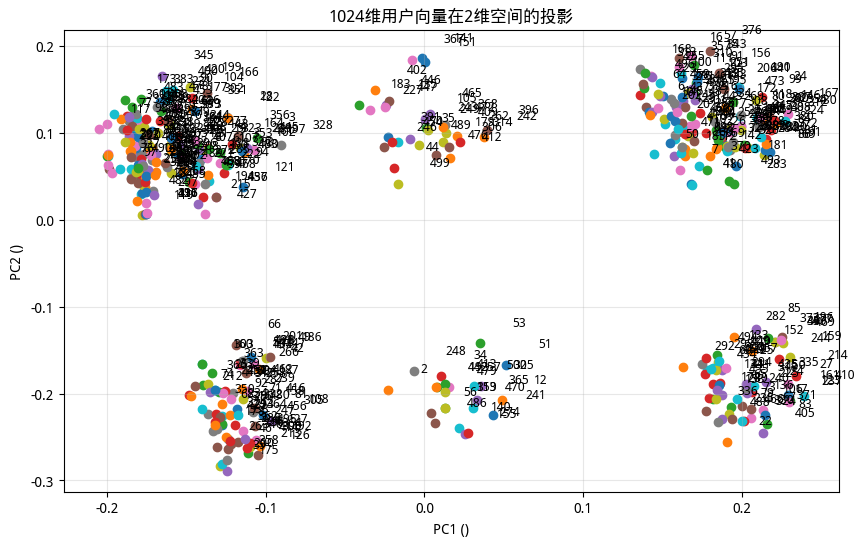

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

plt.rcParams['font.sans-serif'] = ['WenQuanYi Micro Hei']  # 例如，设置为黑体，适用于中文
plt.rcParams['axes.unicode_minus'] = False    # 正确显示负号

# PCA（Principal Component Analysis）是一种无监督的降维技术，通过线性变换将高维数据投影到低维空间，同时保留数据的主要特征。它的核心思想是找到数据中方差最大的方向（主成分），并将数据重新投影到这些方向上。

# 将1024维降至2维可视化，1024维太高，无法直接可视，所以做降维处理。
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(dense_vectors)

# 获取主成分的构成
components = pca.components_
print("第一个主成分（PC1）的构成:", components[0])
print("第二个主成分（PC2）的构成:", components[1])
print("各主成分解释方差比例:", pca.explained_variance_ratio_)

# 二维数据展示到散点图片上
plt.figure(figsize=(10,6))
for i, (x,y) in enumerate(vectors_2d):
    plt.scatter(x, y, label=f'User{i+1}')
    plt.text(x+0.02, y+0.02, f'{i+1}', fontsize=9)
    
plt.title('1024维用户向量在2维空间的投影')
plt.xlabel('PC1 ()')
plt.ylabel('PC2 ()')
plt.grid(alpha=0.3)
plt.legend().set_visible(False)
plt.show()